In [1]:
from tensorflow.keras.models import load_model
from tensorflow.data import Dataset
import tensorflow as tf
import pandas as pd
import json
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2024-12-28 11:23:13.117733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735384993.134140    1562 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735384993.138992    1562 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-28 11:23:13.156220: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Loading Dataset and setup

In [3]:
# Loading the history takes up gpu 
# So Different Files are created 

# Pickle 1 : cnn-1, resnet50_pretrained, resnet18_1, resnet50_2 
# with open("./aptos2019_history.pkl","rb") as file:
#     history = pickle.load(file)

# Pickle 2 : resnet50_1
with open("./aptos2019_history_2.pkl","rb") as file:
    history = pickle.load(file)

print(history)
    
# Loading Config
with open("../config.json") as file:
    config = json.load(file)
 
aptos2019_path = Path(config["dataset"]["aptos_2019"]["balanced_resized"])
models_trained_path = Path(config["models_trained"])
models_path = Path(config["models_folder"])

# All Models Available
model_cnn_1_path = models_path / "cnn_1.keras"
model_resnet50_pretrained_1_path = models_path / "resnet50_pretrained_1.keras"
model_resnet18_1_path = models_path / "resnet18_1.keras"
model_resnet50_1_path = models_path / "resnet50_1.keras"
model_resnet50_2_path = models_path / "resnet50_2.keras"

{}


In [5]:
csv = pd.read_csv(aptos2019_path / "labels.csv")
images_path = str(aptos2019_path / "images")

num_class = 5
def name2image_class2onehot(tensor):
    # Loading and processing image
    image_name = "/" + tensor["img_name"] + ".png"
    image_path = images_path + image_name
    image_file = tf.io.read_file(image_path)
    image_file = tf.io.decode_png(image_file,channels=3)
    image_file = tf.cast(image_file,tf.float32)
    image_file = tf.image.resize(image_file,[224,224])
    image_file /= 255.0
    # onehotting the class 
    onehot_class = tf.one_hot(tensor["class"], depth = num_class)
    
    return (image_file, onehot_class)

tf.random.set_seed(342)
aptos2019_dataset = (Dataset
                     .from_tensor_slices(dict(csv))
                     .shuffle(len(csv))
                     .map(name2image_class2onehot))

# Selecting sizes of train, val and test dataset
dataset_size = dict() 
dataset_size["train"] = 0.7 
dataset_size["val"]   = 0.2
dataset_size["test"]  = 0.1

# creating train, test, val datasets
for key in dataset_size:
    dataset_size[key] = int(dataset_size[key] * len(aptos2019_dataset))
dataset = dict()
dataset["train"] = aptos2019_dataset.take(dataset_size["train"]) 
dataset["val"] = aptos2019_dataset.skip(dataset_size["train"]).take(dataset_size["val"])
dataset["test"] = aptos2019_dataset.skip(dataset_size["train"] + dataset_size["val"]).take(dataset_size["test"]) 

# batching the splits
batch_size = 8
dataset["train"] = dataset["train"].batch(batch_size)
dataset["val"] = dataset["val"].batch(batch_size)
#  dataset["test"] = dataset["test"].batch(batch_size)

print("Splitting sizes:")
for key in dataset_size:
    print(f"- {key} size : {dataset_size[key]}")

# example of a tensor from train set
print("\nExample Tensor:")
for tensor in dataset["train"].take(1):
    print("Batched Input shape:", tensor[0].shape)
    print("Batched One-hot Tensor Shape:", tensor[1].shape)
    print("One-hot Tensor numpy", tensor[1].numpy()[0])

Splitting sizes:
- train size : 12959
- val size : 3702
- test size : 1851

Example Tensor:
Batched Input shape: (8, 224, 224, 3)
Batched One-hot Tensor Shape: (8, 5)
One-hot Tensor numpy [0. 0. 0. 0. 1.]


2024-12-28 11:24:00.953359: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
# Utility functions 

def generate_confusion_matrix(model, test_data):
    ground_truths = []
    predictions = []
    for tensor in tqdm(test_data):
        image = tensor[0].numpy()
        image = np.expand_dims(image,0)
        image_class = np.argmax(tensor[1].numpy())
        current_prediction = np.argmax(model.predict([image],verbose=0))
        ground_truths.append(image_class)
        predictions.append(current_prediction)
    conf_matrix = confusion_matrix(ground_truths,predictions)
    
    # Plot the confusion matrix
    conf_fig = ConfusionMatrixDisplay(conf_matrix)
    conf_fig.plot()

def generate_plots(hmodel): 
    # Plotting the accuracy 
    plt.subplot(2,1,1)
    plt.plot(history[hmodel].epoch, history[hmodel].history["categorical_accuracy"],color="blue",label="train")
    plt.plot(history[hmodel].epoch, history[hmodel].history["val_categorical_accuracy"],color="red",label="validation")
    plt.ylabel("Accuracy")
    plt.legend()
    
    # plotting the loss
    plt.subplot(2,1,2)
    plt.plot(history[hmodel].epoch, history[hmodel].history["loss"],color="blue",label="train")
    plt.plot(history[hmodel].epoch, history[hmodel].history["val_loss"],color="red",label="validation")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.show()

#### CNN - 1
* This model is build using research paper.
* More details in train/CNN notebook 

In [4]:
model_cnn_1 = load_model(model_cnn_1_path)

model_cnn_1.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["categorical_accuracy","recall","precision"]
)

history["cnn_1"] = model_cnn_1.fit(
    dataset["train"],
    validation_data = dataset["val"],
    epochs = 50
)

Epoch 1/50


I0000 00:00:1734194657.653530    5193 service.cc:148] XLA service 0x7fc560013300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734194657.653581    5193 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-12-14 16:44:17.712558: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734194657.952454    5193 cuda_dnn.cc:529] Loaded cuDNN version 90300


   4/1620 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - categorical_accuracy: 0.3359 - loss: 2.3357 - precision: 0.0587 - recall: 0.0282

I0000 00:00:1734194663.314811    5193 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1620/1620 ━━━━━━━━━━━━━━━━━━━━ 48s 25ms/step - categorical_accuracy: 0.3303 - loss: 1.5387 - precision: 0.5666 - recall: 0.0968 - val_categorical_accuracy: 0.4571 - val_loss: 1.2682 - val_precision: 0.7971 - val_recall: 0.1475
Epoch 2/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - categorical_accuracy: 0.4445 - loss: 1.2809 - precision: 0.6874 - recall: 0.1953 - val_categorical_accuracy: 0.5170 - val_loss: 1.1492 - val_precision: 0.7249 - val_recall: 0.2825
Epoch 3/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - categorical_accuracy: 0.5002 - loss: 1.1862 - precision: 0.6954 - recall: 0.2677 - val_categorical_accuracy: 0.5475 - val_loss: 1.0985 - val_precision: 0.6951 - val_recall: 0.3855
Epoch 4/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - categorical_accuracy: 0.5331 - loss: 1.1179 - precision: 0.7020 - recall: 0.3186 - val_categorical_accuracy: 0.5937 - val_loss: 0.9971 - val_precision: 0.7480 - val_recall: 0.4017
Epoch 5/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - c

In [5]:
model_cnn_1.save(models_trained_path / "cnn_1.keras")

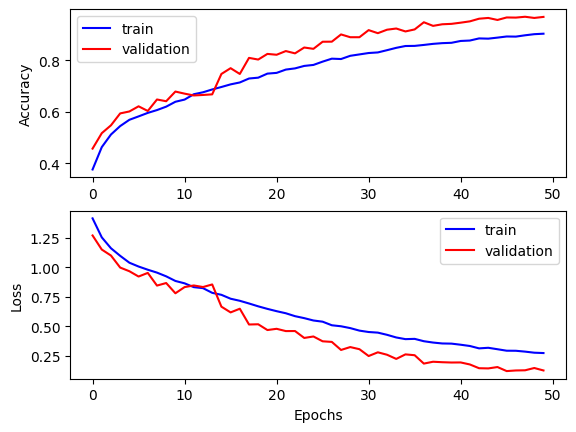

In [6]:
generate_plots("cnn_1")

  0%|                                                                                          | 0/1851 [00:00<?, ?it/s]/home/karthikgpu/tf_gpu/tf218/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: input_layer. Received: the structure of inputs=('*',)
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████| 1851/1851 [02:03<00:00, 14.99it/s]


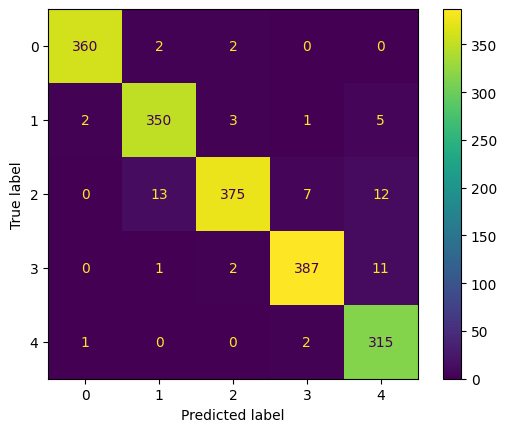

In [22]:
generate_confusion_matrix(model_cnn_1, dataset["test"]) 

#### Pretrained Resnet50 - 1
* Built-in tensorflow model with imagenet weights.
* Average Pooling -> Dense(512) -> Dense(5,"softmax")

In [4]:
model_resnet50_pretrained_1 = load_model(model_resnet50_pretrained_1_path)

model_resnet50_pretrained_1.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["categorical_accuracy","recall","precision"]
)

history["resnet50_pretrained_1"] = model_resnet50_pretrained_1.fit(
    dataset["train"],
    validation_data = dataset["val"],
    epochs = 50
)

Epoch 1/50


I0000 00:00:1735012600.568553     691 service.cc:148] XLA service 0x7f6b300037b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735012600.569039     691 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-12-24 03:56:41.368550: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735012604.579887     691 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-24 03:56:46.250851: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15506_0', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1735012634.304361     691 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1619/1620 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - categorical_accuracy: 0.3174 - loss: 1.5518 - precision: 0.6141 - recall: 0.0834

2024-12-24 04:00:48.791211: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15506_0', 8 bytes spill stores, 8 bytes spill loads



1620/1620 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - categorical_accuracy: 0.3174 - loss: 1.5517 - precision: 0.6142 - recall: 0.0834

2024-12-24 04:01:44.549173: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1733_0', 8 bytes spill stores, 8 bytes spill loads



1620/1620 ━━━━━━━━━━━━━━━━━━━━ 334s 169ms/step - categorical_accuracy: 0.3175 - loss: 1.5517 - precision: 0.6143 - recall: 0.0835 - val_categorical_accuracy: 0.3576 - val_loss: 1.3832 - val_precision: 0.7774 - val_recall: 0.1189
Epoch 2/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 209s 129ms/step - categorical_accuracy: 0.4605 - loss: 1.2354 - precision: 0.6976 - recall: 0.2050 - val_categorical_accuracy: 0.4111 - val_loss: 1.5158 - val_precision: 0.5163 - val_recall: 0.2904
Epoch 3/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 237s 146ms/step - categorical_accuracy: 0.5319 - loss: 1.0620 - precision: 0.7105 - recall: 0.3094 - val_categorical_accuracy: 0.5065 - val_loss: 1.1563 - val_precision: 0.6091 - val_recall: 0.3822
Epoch 4/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 236s 146ms/step - categorical_accuracy: 0.5826 - loss: 0.9659 - precision: 0.7114 - recall: 0.3940 - val_categorical_accuracy: 0.4854 - val_loss: 1.5213 - val_precision: 0.5519 - val_recall: 0.3909
Epoch 5/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 236s 146m

In [5]:
model_resnet50_pretrained_1.save(models_trained_path / "resnet50_pretrained_1.keras")

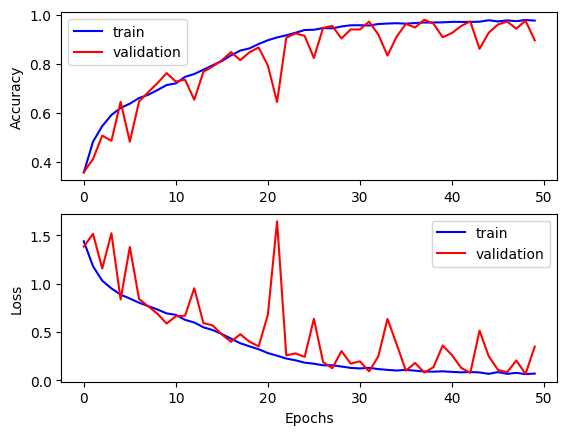

In [7]:
generate_plots("resnet50_pretrained_1")

  0%|                                                                                          | 0/1851 [00:00<?, ?it/s]/home/karthikgpu/tf_gpu/tf218/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: input_layer_4. Received: the structure of inputs=('*',)
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████| 1851/1851 [02:32<00:00, 12.11it/s]


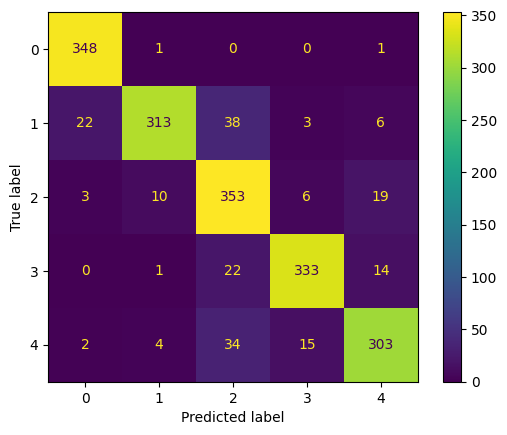

In [7]:
generate_confusion_matrix(model_resnet50_pretrained_1, dataset["test"]) 

#### Resnet18 - 1
* Average Pooling -> Dense(512) -> Dense(5, "Softmax")

In [7]:
model_resnet18_1 = load_model(model_resnet18_1_path) 

model_resnet18_1.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["categorical_accuracy","recall","precision"]
)

history["resnet18_1"] = model_resnet18_1.fit(
    dataset["train"],
    validation_data = dataset["val"],
    epochs = 50
)

Epoch 1/50


I0000 00:00:1735289271.538000     884 service.cc:148] XLA service 0x7fa8f8005080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735289271.539390     884 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-12-27 08:47:51.879662: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735289273.202718     884 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1735289291.090957     884 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1620/1620 ━━━━━━━━━━━━━━━━━━━━ 180s 92ms/step - categorical_accuracy: 0.2971 - loss: 1.6122 - precision: 0.5490 - recall: 0.0687 - val_categorical_accuracy: 0.4001 - val_loss: 1.3556 - val_precision: 0.7392 - val_recall: 0.1432
Epoch 2/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 126s 78ms/step - categorical_accuracy: 0.3836 - loss: 1.3662 - precision: 0.7625 - recall: 0.1224 - val_categorical_accuracy: 0.3936 - val_loss: 1.4259 - val_precision: 0.6024 - val_recall: 0.1915
Epoch 3/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 127s 78ms/step - categorical_accuracy: 0.4119 - loss: 1.3181 - precision: 0.7589 - recall: 0.1525 - val_categorical_accuracy: 0.4311 - val_loss: 1.2707 - val_precision: 0.7249 - val_recall: 0.1680
Epoch 4/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 126s 78ms/step - categorical_accuracy: 0.4187 - loss: 1.2948 - precision: 0.7709 - recall: 0.1592 - val_categorical_accuracy: 0.4311 - val_loss: 1.3066 - val_precision: 0.6014 - val_recall: 0.2788
Epoch 5/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 126s 78ms/ste

In [9]:
model_resnet18_1.save(models_trained_path / "resnet18_1.keras")

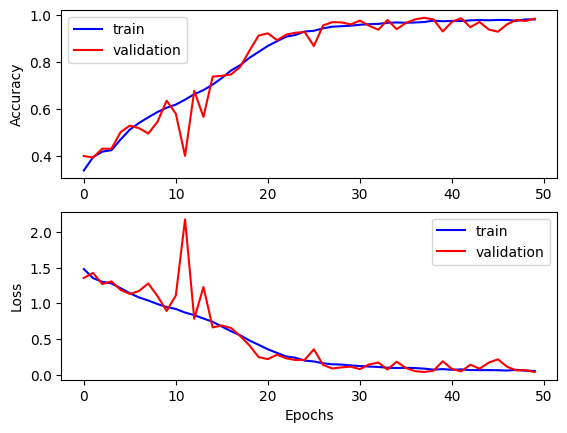

In [8]:
generate_plots("resnet18_1")

  0%|                                                                                                                                                                                                                | 0/1851 [00:00<?, ?it/s]/home/karthikgpu/tf_gpu/tf218/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: input_layer_36. Received: the structure of inputs=('*',)
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1851/1851 [02:26<00:00, 12.63it/s]


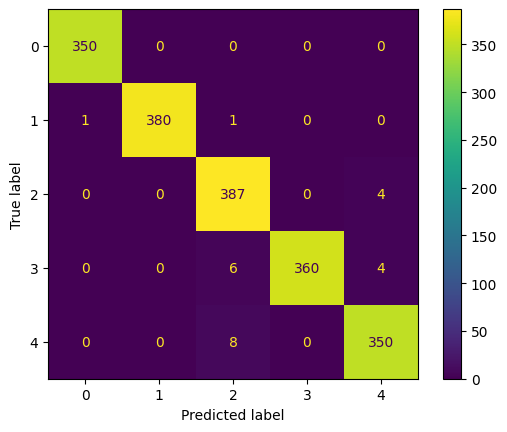

In [10]:
generate_confusion_matrix(model_resnet18_1, dataset["test"]) 

#### Resnet50 - 1
* Average Pooling -> Dense(512) -> Dense(5, "Softmax")

In [7]:
model_resnet50_1 = load_model(model_resnet50_1_path) 

model_resnet50_1.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["categorical_accuracy","recall","precision"]
)

history["resnet50_1"] = model_resnet50_1.fit(
    dataset["train"],
    validation_data = dataset["val"],
    epochs = 50
)

Epoch 1/50


I0000 00:00:1735385073.905917    1616 service.cc:148] XLA service 0x7f1ae8002880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735385073.905961    1616 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-12-28 11:24:34.590902: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735385077.421753    1616 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-28 11:24:39.357117: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15140_0', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1735385107.032882    1616 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1619/1620 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - categorical_accuracy: 0.3288 - loss: 2.1160 - precision: 0.4351 - recall: 0.1256

2024-12-28 11:28:40.297598: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15140_0', 8 bytes spill stores, 8 bytes spill loads



1620/1620 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - categorical_accuracy: 0.3289 - loss: 2.1156 - precision: 0.4351 - recall: 0.1256

2024-12-28 11:29:38.416473: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1367_0', 8 bytes spill stores, 8 bytes spill loads



1620/1620 ━━━━━━━━━━━━━━━━━━━━ 334s 170ms/step - categorical_accuracy: 0.3289 - loss: 2.1152 - precision: 0.4352 - recall: 0.1257 - val_categorical_accuracy: 0.3820 - val_loss: 1.5455 - val_precision: 0.5140 - val_recall: 0.1988
Epoch 2/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 234s 144ms/step - categorical_accuracy: 0.4456 - loss: 1.2843 - precision: 0.6560 - recall: 0.1865 - val_categorical_accuracy: 0.5078 - val_loss: 1.2147 - val_precision: 0.6654 - val_recall: 0.2923
Epoch 3/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 234s 144ms/step - categorical_accuracy: 0.4935 - loss: 1.1973 - precision: 0.6768 - recall: 0.2462 - val_categorical_accuracy: 0.4406 - val_loss: 1.4255 - val_precision: 0.5285 - val_recall: 0.3004
Epoch 4/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 234s 144ms/step - categorical_accuracy: 0.4979 - loss: 1.1654 - precision: 0.6893 - recall: 0.2753 - val_categorical_accuracy: 0.5116 - val_loss: 1.2179 - val_precision: 0.6157 - val_recall: 0.3744
Epoch 5/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 233s 144m

In [8]:
model_resnet50_1.save(models_trained_path / "resnet50_1.keras")

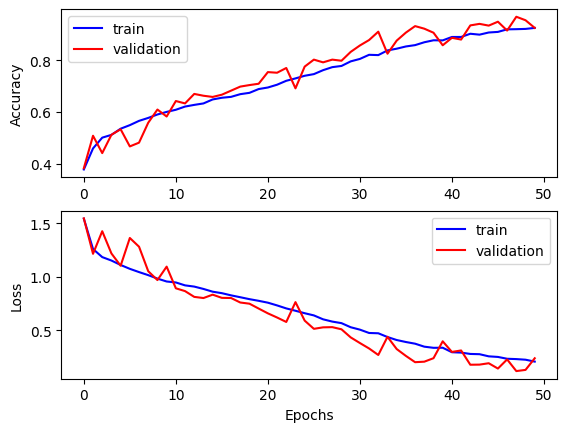

In [10]:
generate_plots("resnet50_1") 

  0%|                                                                                          | 0/1851 [00:00<?, ?it/s]/home/karthikgpu/tf_gpu/tf218/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: input_layer. Received: the structure of inputs=('*',)
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████| 1851/1851 [02:30<00:00, 12.30it/s]


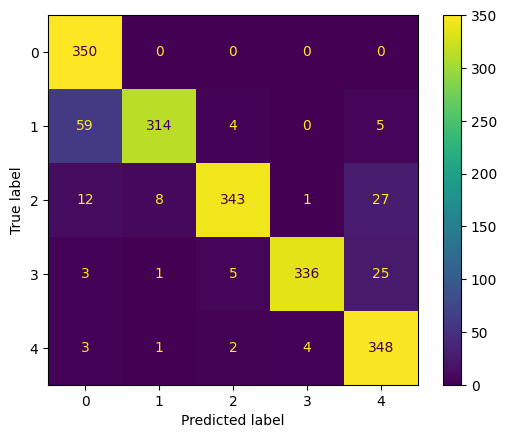

In [11]:
generate_confusion_matrix(model_resnet50_1, dataset["test"])

#### Resnet50 - 2
* Average Pooling -> Dense(5, "Softmax")

In [4]:
model_resnet50_2 = load_model(model_resnet50_2_path) 

model_resnet50_2.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["categorical_accuracy","recall","precision"]
)

history["resnet50_2"] = model_resnet50_2.fit(
    dataset["train"],
    validation_data = dataset["val"],
    epochs = 50
)

Epoch 1/50


I0000 00:00:1735364179.492446    2526 service.cc:148] XLA service 0x7efc0c005cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735364179.492628    2526 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-12-28 05:36:20.189684: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735364183.110576    2526 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-28 05:36:25.123929: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15106', 168 bytes spill stores, 168 bytes spill loads

I0000 00:00:1735364208.405436    2526 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1619/1620 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - categorical_accuracy: 0.3194 - loss: 2.3381 - precision: 0.4316 - recall: 0.1231

2024-12-28 05:40:19.292842: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15106', 152 bytes spill stores, 152 bytes spill loads



1620/1620 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - categorical_accuracy: 0.3194 - loss: 2.3377 - precision: 0.4317 - recall: 0.1230

2024-12-28 05:41:11.514533: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1365', 140 bytes spill stores, 140 bytes spill loads



1620/1620 ━━━━━━━━━━━━━━━━━━━━ 321s 164ms/step - categorical_accuracy: 0.3194 - loss: 2.3372 - precision: 0.4317 - recall: 0.1230 - val_categorical_accuracy: 0.2893 - val_loss: 1.9187 - val_precision: 0.3560 - val_recall: 0.1623
Epoch 2/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 232s 143ms/step - categorical_accuracy: 0.3952 - loss: 1.3696 - precision: 0.7042 - recall: 0.1342 - val_categorical_accuracy: 0.3061 - val_loss: 2.6115 - val_precision: 0.3724 - val_recall: 0.2693
Epoch 3/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 233s 144ms/step - categorical_accuracy: 0.4589 - loss: 1.2643 - precision: 0.6779 - recall: 0.2048 - val_categorical_accuracy: 0.4122 - val_loss: 1.5938 - val_precision: 0.4745 - val_recall: 0.3614
Epoch 4/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 233s 144ms/step - categorical_accuracy: 0.4782 - loss: 1.2212 - precision: 0.6680 - recall: 0.2331 - val_categorical_accuracy: 0.4238 - val_loss: 1.4175 - val_precision: 0.4675 - val_recall: 0.3514
Epoch 5/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 233s 144m

In [6]:
model_resnet50_2.save(models_trained_path / "resnet50_2.keras")

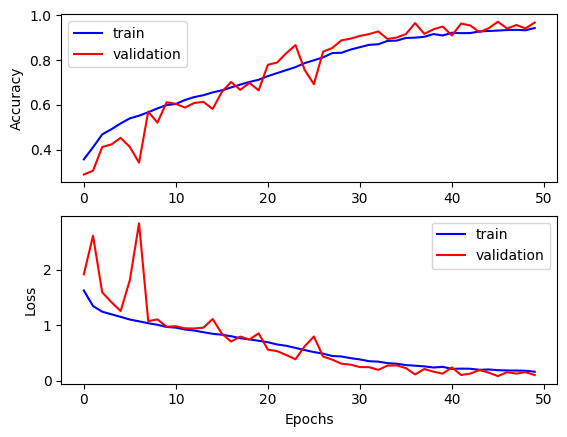

In [9]:
generate_plots("resnet50_2")

  0%|                                                                                          | 0/1851 [00:00<?, ?it/s]/home/karthikgpu/tf_gpu/tf218/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: input_layer. Received: the structure of inputs=('*',)
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████| 1851/1851 [02:31<00:00, 12.24it/s]


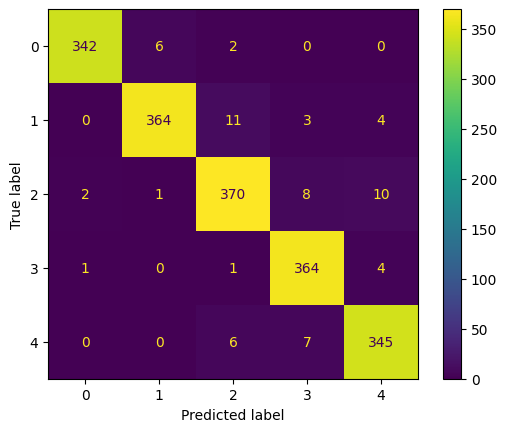

In [7]:
generate_confusion_matrix(model_resnet50_2, dataset["test"]) 

#### Save Training History

In [13]:
# Saving the history
# Pickle 1
# with open("./aptos2019_history.pkl","wb") as file:
# pickle.dump(history,file)

# Pickle 2
with open("./aptos2019_history_2.pkl","wb") as file:
    pickle.dump(history,file)